# DataJoint Elements for Array Electrophysiology with NeuroPixels

#### Open-source data pipeline for processing and analyzing extracellular electrophysiology datasets.

Welcome to the tutorial for the DataJoint Element for extracellular array
electrophysiology. This tutorial aims to provide a comprehensive understanding of the
open-source data pipeline created using `element-array-ephys`.

This package is designed to seamlessly process, ingest, and track extracellular
electrophysiology data, along with its associated probe and recording metadata. By the
end of this tutorial you will have a clear grasp on setting up and integrating
`element-array-ephys` into your specific research projects and lab.

![flowchart](../images/diagram_flowchart.svg)

### Prerequisites

Please see the
[datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main)
before proceeding.

A basic understanding of the following DataJoint concepts will be beneficial to your
understanding of this tutorial:

1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method.

#### **Tutorial Overview**

- Setup
- _Activate_ the DataJoint pipeline.
- _Insert_ subject, session, and probe metadata.
- _Populate_ electrophysiology recording metadata.
- Run the clustering task.
- Curate the results (optional).
- Visualize the results.

### **Setup**

This tutorial examines extracellular electrophysiology data acquired with `OpenEphys`
and spike-sorted using Kilosort 2.5. The goal is to store, track and manage sessions of
array electrophysiology data, including spike sorting results and unit-level
visualizations.

The results of this Element can be combined with **other modalities** to create a
complete, customizable data pipeline for your specific lab or study. For instance, you
can combine `element-array-ephys` with `element-calcium-imaging` and
`element-deeplabcut` to characterize the neural activity along with markless
pose-estimation during behavior.

Let's start this tutorial by importing the packages necessary to run the notebook.


In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
Let's connect to the database server.


In [2]:
dj.conn()

[2025-07-08 16:16:32,291][INFO]: DataJoint 0.14.4 connected to root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `ephys_acute.py` module from `element-array-ephys`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to
the [`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.


In [3]:
from tests.tutorial_pipeline import lab, subject, session, probe, ephys

[2025-07-08 16:16:33,892][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `probe` and `ephys` schemas as well as some of the
upstream dependencies to `session` and `subject` schemas as a diagram.


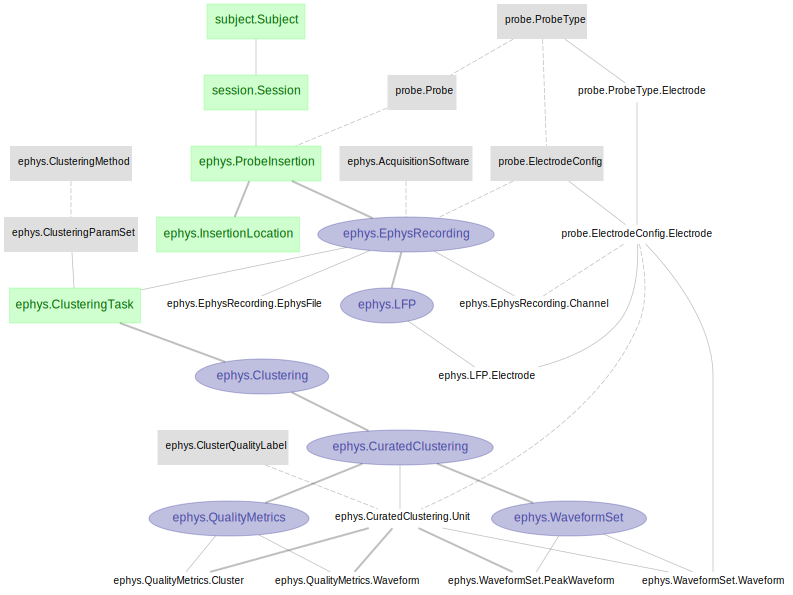

In [4]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(probe)
    + dj.Diagram(ephys)
)

As evident from the diagram, this data pipeline encompasses tables associated with
recording and probe metadata, results of clustering. A few tables, such as
`subject.Subject` or `session.Session`, while important for a complete pipeline, fall
outside the scope of the `element-array-ephys` tutorial, and will therefore, not be
explored extensively here. The primary focus of this tutorial will be on the `probe` and
`ephys` schemas.

### **Insert subject, session, and probe metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes
using the `.describe()` and `.heading` methods.


In [5]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject5,,U,2023-01-01,


In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table. We will insert data into the
`subject.Subject` table.


In [ ]:
subject.Subject.insert1(
    dict(subject="subject5", subject_birth_date="2023-01-01", sex="U")
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject5,,U,2023-01-01,


Let's repeat the steps above for the `Session` table and see how the output varies
between `.describe` and `.heading`.


In [9]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     
---
session_id=null      : int                          



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
---
session_id=null      : int                          # 

Notice that `describe`, displays the table's structure and highlights its dependencies,
such as its reliance on the `Subject` table. These dependencies represent foreign key
references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1`
method.


In [11]:
session_key = dict(subject="subject5", session_datetime="2023-01-01 00:00:00")

In [ ]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime,session_id
subject5,2023-01-01 00:00:00,None


Every experimental session produces a set of data files. The purpose of the
`SessionDirectory` table is to locate these files. It references a directory path
relative to a root directory, defined in `dj.config["custom"]`. More information about
`dj.config` is provided in the
[documentation](https://datajoint.com/docs/elements/user-guide/).


In [ ]:
session.SessionDirectory.insert1(
    dict(**session_key, session_dir="raw/subject5/session1")
)
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject5,2023-01-01 00:00:00,raw/subject5/session1


As the Diagram indicates, the tables in the `probe` schemas need to contain data before
the tables in the `ephys` schema accept any data. Let's start by inserting into
`probe.Probe`, a table containing metadata about a multielectrode probe.


In [ ]:
probe.Probe.insert1(
    dict(probe="714000838", probe_type="neuropixels 1.0 - 3B")
)  # this info could be achieve from neuropixels meta file.
probe.Probe()

probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
714000838,neuropixels 1.0 - 3B,


The probe metadata is used by the downstream `ProbeInsertion` table which we insert data
into in the cells below:


In [20]:
print(ephys.ProbeInsertion.describe())

# Probe insertion implanted into an animal for a given session.
-> session.Session
insertion_number     : tinyint unsigned             
---
-> probe.Probe



In [21]:
ephys.ProbeInsertion.heading

# Probe insertion implanted into an animal for a given session.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
---
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)

In [ ]:
ephys.ProbeInsertion.insert1(
    dict(
        session_key,
        insertion_number=1,
        probe="714000838",
    )
)  # probe, subject, session_datetime needs to follow the restrictions of foreign keys.
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject5,2023-01-01 00:00:00,1,714000838


Confirm the inserted data:


In [24]:
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject5,2023-01-01 00:00:00,1,714000838


### **Populate electrophysiology recording metadata**

In the upcoming cells, the `.populate()` method will automatically extract and store the
recording metadata for each experimental session in the `ephys.EphysRecording` table and
its part table `ephys.EphysRecording.EphysFile`.


In [25]:
ephys.EphysRecording()

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),recording_datetime datetime of the recording from this probe,recording_duration (seconds) duration of the recording from this probe
subject5,2023-01-01 00:00:00,1,8d4cc6d8-a02d-42c8-bf27-7459c39ea0ee,SpikeGLX,30000.0,2018-07-03 20:32:28,338.666


In [26]:
ephys.EphysRecording.EphysFile()

subject,session_datetime,insertion_number,file_path filepath relative to root data directory
subject5,2023-01-01 00:00:00,1,raw/subject5/session1/probe_1/npx_g0_t0.imec.ap.meta


In [27]:
ephys.EphysRecording.populate(session_key, display_progress=True)

{'success_count': 0, 'error_list': []}

Let's view the information was entered into each of these tables:


In [28]:
ephys.EphysRecording()

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),recording_datetime datetime of the recording from this probe,recording_duration (seconds) duration of the recording from this probe
subject5,2023-01-01 00:00:00,1,8d4cc6d8-a02d-42c8-bf27-7459c39ea0ee,SpikeGLX,30000.0,2018-07-03 20:32:28,338.666


In [29]:
ephys.EphysRecording.EphysFile()

subject,session_datetime,insertion_number,file_path filepath relative to root data directory
subject5,2023-01-01 00:00:00,1,raw/subject5/session1/probe_1/npx_g0_t0.imec.ap.meta


### **Run the Clustering Task**

We're almost ready to spike sort the data with `kilosort`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the kilosort parameters in a dictionary and insert them into a DataJoint table
`ClusteringParamSet`. This table keeps track of all combinations of your spike sorting
parameters. You can choose which parameters are used during processing in a later step.

Let's view the attributes and insert data into `ephys.ClusteringParamSet`.


In [30]:
ephys.ClusteringParamSet.heading

# Parameter set to be used in a clustering procedure
paramset_idx         : smallint                     # 
---
clustering_method    : varchar(16)                  # 
paramset_desc        : varchar(128)                 # 
param_set_hash       : uuid                         # 
params               : longblob                     # dictionary of all applicable parameters

In [31]:
# insert clustering task manually
params = {}
params["SI_PREPROCESSING_METHOD"] = "CatGT"
params["SI_SORTING_PARAMS"] = {
    "minfr_goodchannels": 0.1,
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "scaleproc": 200,
    "nPCs": 3,
}
params["SI_POSTPROCESSING_PARAMS"] = {
    "extensions": {
        "random_spikes": {},
        "waveforms": {},
        "templates": {},
        "noise_levels": {},
        # "amplitude_scalings": {},
        "correlograms": {},
        "isi_histograms": {},
        "principal_components": {"n_components": 5, "mode": "by_channel_local"},
        "spike_amplitudes": {},
        "spike_locations": {},
        "template_metrics": {"include_multi_channel_metrics": True},
        "template_similarity": {},
        "unit_locations": {},
        "quality_metrics": {},
    },
    "job_kwargs": {"n_jobs": 0.8, "chunk_duration": "1s"},
    "export_to_phy": True,
    "export_report": True,
}

ephys.ClusteringParamSet.insert_new_params(
    clustering_method="kilosort2",
    paramset_idx=0,
    params=params,
    paramset_desc="Spike sorting using Kilosort2",
)
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,1be14ec5-8c8a-6d86-e766-f31042931575,=BLOB=


DataJoint uses a `ClusteringTask` table to manage which `EphysRecording` and
`ClusteringParamSet` should be used during processing.

This table is important for defining several important aspects of downstream processing.
Let's view the attributes to get a better understanding.


In [32]:
ephys.ClusteringTask.heading

# Manual table for defining a clustering task ready to be run
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
---
clustering_output_dir="" : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation

The `ClusteringTask` table contains two important attributes:

- `paramset_idx` - Allows the user to choose the parameter set with which you want to
  run spike sorting.
- `task_mode` - Can be set to `load` or `trigger`. When set to `load`, running the
  Clustering step initiates a search for existing output files of the spike sorting
  algorithm defined in `ClusteringParamSet`. When set to `trigger`, the processing step
  will run spike sorting on the raw data.


In [ ]:
ephys.ClusteringTask.insert1(
    dict(
        session_key,
        insertion_number=1,
        paramset_idx=0,
        task_mode="load",  # load or trigger
        clustering_output_dir="processed/subject5/session1/probe_1/kilosort2-5_1",
    )
)

Let's call populate on the `Clustering` table which checks for kilosort results since
`task_mode=load`.


In [34]:
ephys.Clustering.populate(session_key, display_progress=True)

{'success_count': 0, 'error_list': []}

### **Populate the results**

Once the `Clustering` table receives an entry, we can populate the remaining tables in
the workflow including `CuratedClustering`, `WaveformSet`, and `LFP`.


In [35]:
ephys.CuratedClustering.populate(session_key, display_progress=True)
ephys.LFP.populate(session_key, display_progress=True)
ephys.WaveformSet.populate(session_key, display_progress=True)

{'success_count': 0, 'error_list': []}

Now that we've populated the tables in this DataJoint pipeline, there are one of several
next steps. If you have an existing pipeline for aligning waveforms to behavior data or
other stimuli, you can easily invoke `element-event` or define your custom DataJoint
tables to extend the pipeline.


### **Visualize the results**


In this tutorial, we will do some exploratory analysis by fetching the data from the
database and creating a few plots.


Let's start by visualizing the Local Field Potential (LFP), which represents the combined electrical activity from multiple neurons in a local brain region.

In [36]:
lfp_key = (ephys.LFP & "insertion_number = '1'").fetch("KEY")

In [37]:
ephys.LFP & lfp_key

subject,session_datetime,insertion_number,lfp_sampling_rate (Hz),lfp_time_stamps (s) timestamps with respect to the start of the recording (recording_timestamp),"lfp_mean (uV) mean of LFP across electrodes - shape (time,)"
subject5,2023-01-01 00:00:00,1,2500.0,=BLOB=,=BLOB=


In [38]:
lfp_signal, timestamps, fs = (ephys.LFP & lfp_key).fetch1(
    "lfp_mean", "lfp_time_stamps", "lfp_sampling_rate"
)

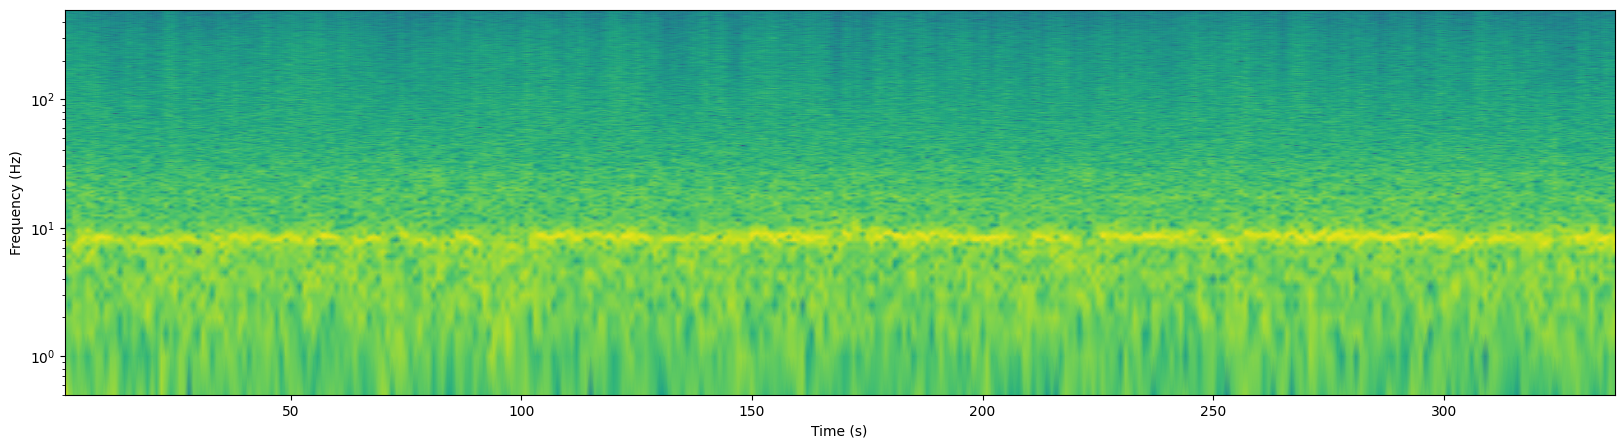

In [39]:
from scipy import signal

window_size = 2.0
overlap_size = 1.0
nperseg = int(window_size * fs)
noverlap = int(overlap_size * fs)
f, t, Sxx = signal.spectrogram(
    lfp_signal,
    fs=fs,
    window="tukey",
    nperseg=nperseg,
    noverlap=noverlap,
    scaling="density",
    mode="psd",
)
fig, ax = plt.subplots(figsize=(20, 5))
ax.pcolormesh(t, f[1:1000], np.log(Sxx[1:1000]), shading="gouraud")
plt.yscale("log")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.show()

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of your
analysis workflow. This can also make the queries seem more complex at first. However,
we'll walk through them slowly to simplify their content in this notebook.

The examples below perform several operations using DataJoint queries:

- Fetch the primary key attributes of all units that are in `insertion_number=1`.
- Use **multiple restrictions** to fetch timestamps and create a raster plot.
- Use a **join** operation and **multiple restrictions** to fetch a waveform trace,
  along with unit data to create a single waveform plot


In [40]:
insert_key = (ephys.ProbeInsertion & "insertion_number = '1'").fetch1("KEY")
units, unit_spiketimes = (
    ephys.CuratedClustering.Unit
    & insert_key
    & 'unit IN ("6","7","9","14","15","17","19")'
).fetch("unit", "spike_times")

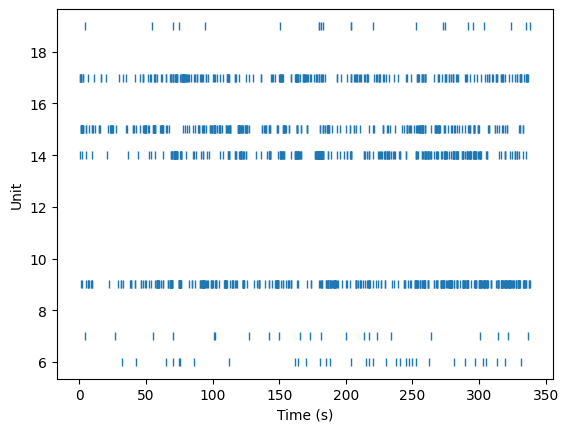

In [41]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])
plt.plot(x, y, "|")
plt.xlabel("Time (s)")
plt.ylabel("Unit");

Below we will use two queries to fetch _all_ of the information about a single unit and
plot the unit waveform.


In [42]:
unit_key = (ephys.CuratedClustering.Unit & insert_key & "unit = '15'").fetch1("KEY")
unit_data = (
    ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key
).fetch1()

In [43]:
unit_data

{'subject': 'subject5',
 'session_datetime': datetime.datetime(2023, 1, 1, 0, 0),
 'insertion_number': 1,
 'paramset_idx': 0,
 'unit': 15,
 'electrode_config_hash': UUID('8d4cc6d8-a02d-42c8-bf27-7459c39ea0ee'),
 'probe_type': 'neuropixels 1.0 - 3A',
 'electrode': 92,
 'cluster_quality_label': 'noise',
 'spike_count': 292,
 'spike_times': array([  1.02606667,   1.19973333,   1.5044    ,   1.52283333,
          1.86786667,   1.8688    ,   1.8806    ,   1.88553333,
          2.0581    ,   2.76826667,   2.89186667,   2.9311    ,
          4.8753    ,   5.2964    ,   7.02266667,   9.65273333,
          9.81373333,  10.22443333,  11.96146667,  15.07173333,
         15.08983333,  15.78326667,  21.30936667,  22.7549    ,
         23.5582    ,  23.6582    ,  23.87043333,  24.16726667,
         24.25456667,  24.2671    ,  25.0249    ,  27.89116667,
         35.3036    ,  36.0171    ,  40.00396667,  40.0873    ,
         41.015     ,  42.70086667,  45.8682    ,  47.9291    ,
         48.90843333,

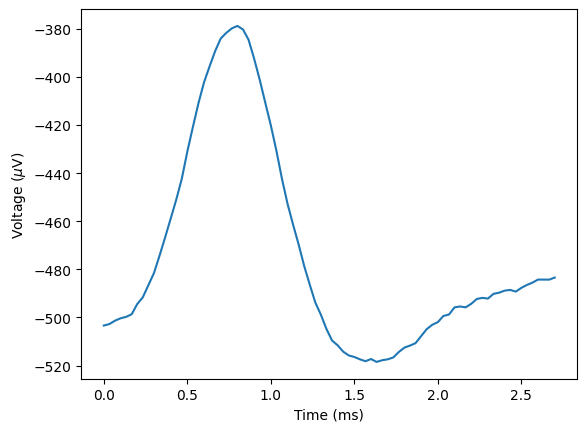

In [44]:
sampling_rate = (ephys.EphysRecording & insert_key).fetch1(
    "sampling_rate"
) / 1000  # in kHz
plt.plot(
    np.r_[: unit_data["peak_electrode_waveform"].size] * 1 / sampling_rate,
    unit_data["peak_electrode_waveform"],
)
plt.xlabel("Time (ms)")
plt.ylabel(r"Voltage ($\mu$V)");

## Summary

Following this tutorial, we have:

- Covered the essential functionality of `element-array-ephys`.
- Learned how to manually insert data into tables.
- Executed and ingested results of spike sorting with Kilosort.
- Visualized the results.

#### Documentation and DataJoint Tutorials

- [Detailed documentation on `element-array-ephys`.](https://datajoint.com/docs/elements/element-array-ephys/)
- [General `datajoint-python` tutorials.](https://github.com/datajoint/datajoint-tutorials)
  covering fundamentals, such as table tiers, query operations, fetch operations,
  automated computations with the make function, and more.
- [Documentation for `datajoint-python`.](https://datajoint.com/docs/core/datajoint-python/)

##### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:

- Download the
  [mysql-docker image for DataJoint](https://github.com/datajoint/mysql-docker) and run
  the container according to the instructions provide in the repository.
- Create a fork of this repository to your GitHub account.
- Clone the repository and open the files using your IDE.
- Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code.

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

- Run the code block above and proceed with the rest of the notebook.
